<font color='#E27271'>

# *Unveiling Complex Interconnections Among Companies through Learned Embeddings*</font>

-----------------------
<font color='#E27271'>

Ethan Moody, Eugene Oon, and Sam Shinde</font>

<font color='#E27271'>

August 2023</font>

-----------------------
<font color='#00AED3'>

# **Model: Sentence Transformers** </font>
-----------------------

We will use [Sentence Transformers](https://www.sbert.net/index.html) to encode sentences from Item 1 ("Business") of SEC 10-K reports for companies listed on NYSE and NASDAQ. The goal is to predict the GICS sector classification for these companies by applying a classification head. It is important to note that we will not fine-tune the Sentence Transformers for the classification task; instead, we will focus on training the classification head using fixed embeddings as input.

## [1] Installs, Imports and Setup Steps

### [1.1] Complete Initial Installs

In [ ]:
!pip install -U sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00


### [1.2] Import Packages

In [ ]:
import json
import numpy as np
import pandas as pd
import re

import nltk
nltk.download('punkt')

from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### [1.3] Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## [2] Modeling Data Preparation

### [2.1] Load full training data from json, extract relevant sections and extract to csv

In [ ]:
# Define the path to the JSON file containing the data
file_nsp500 = '/content/drive/My Drive/Colab Notebooks/project/data/10K/nsp500_final.json'

# Read the JSON data into a pandas DataFrame
df_train_json = pd.read_json(file_nsp500)

# Extract rows from the DataFrame that have "year" equal to 2022 and "formType" equal to "10-K"
df_train_extract = df_train_json[(df_train_json["year"] == 2022) & (df_train_json["formType"] == "10-K")]

# Drop duplicate rows based on the "name" column, keeping only the first occurrence
df_train_extract = df_train_extract.drop_duplicates("name")

# Create a new column "business_length" that contains the length of the text in the "business" column
df_train_extract["business_length"] = df_train_extract["business"].apply(lambda x: len(x))
# Keep only rows where the "business_length" is greater than 5000 (assuming text length is measured in characters)
df_train_extract = df_train_extract[df_train_extract["business_length"] > 5000]

# Filter out rows where either the "sector" or "business" column is missing (null/NaN)
df_train_extract = df_train_extract[(df_train_extract["sector"].notnull()) & (df_train_extract["business"].notnull())]

# Keep only the columns "name", "ticker", "cik", "business", and "sector"
df_train_extract = df_train_extract[["name","ticker","cik","business","sector"]]

# Print information about the DataFrame to check, including the number of non-null values and data types
print(df_train_extract.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3682 entries, 0 to 3694
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      3682 non-null   object
 1   ticker    3682 non-null   object
 2   cik       3682 non-null   int64 
 3   business  3682 non-null   object
 4   sector    3682 non-null   object
dtypes: int64(1), object(4)
memory usage: 172.6+ KB
None


### [2.2] Load filtered training data from csv

In [ ]:
# Define the path where the extracted data will be saved as a CSV file
output_train_csv_path = '/content/drive/My Drive/Colab Notebooks/project/eugene/nsp500_2022bus_final.csv'

# # Save the DataFrame "df_train_extract" to the specified CSV file
df_train_extract.to_csv(output_train_csv_path,index=False)

# Read the CSV file back into a new DataFrame "df_train"
df_train = pd.read_csv(output_train_csv_path)

### [2.3] Load full testing data from json, extract relevant sections and extract to csv

In [ ]:
# Define the path to the JSON file containing the data
file_sp500 = '/content/drive/My Drive/Colab Notebooks/project/data/10K/sp500_final.json'

# Read the JSON data into a pandas DataFrame
df_test_json = pd.read_json(file_sp500)

# Extract rows from the DataFrame that have "year" equal to 2022 and "formType" equal to "10-K"
df_test_extract = df_test_json[(df_test_json["year"] == 2022) & (df_test_json["formType"] == "10-K")]

# Drop duplicate rows based on the "name" column, keeping only the first occurrence
df_test_extract = df_test_extract.drop_duplicates("name")

# Create a new column "business_length" that contains the length of the text in the "business" column
df_test_extract["business_length"] = df_test_extract["business"].apply(lambda x: len(x))
# Keep only rows where the "business_length" is greater than 5000 (assuming text length is measured in characters)
df_test_extract = df_test_extract[df_test_extract["business_length"] > 5000]

# Filter out rows where either the "sector" or "business" column is missing (null/NaN)
df_test_extract = df_test_extract[(df_test_extract["sector"].notnull()) & (df_test_extract["business"].notnull())]

# Keep only the columns "name", "ticker", "cik", "business", and "sector"
df_test_extract = df_test_extract[["name","ticker","cik","business","sector"]]

# Print information about the DataFrame to check, including the number of non-null values and data types
print(df_test_extract.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      500 non-null    object
 1   ticker    500 non-null    object
 2   cik       500 non-null    object
 3   business  500 non-null    object
 4   sector    500 non-null    object
dtypes: object(5)
memory usage: 23.4+ KB
None


### [2.4] Load filtered testing data from csv

In [ ]:
# Define the path where the extracted data will be saved as a CSV file
output_test_csv_path = '/content/drive/My Drive/Colab Notebooks/project/eugene/sp500_2022bus_final.csv'

# # Save the DataFrame "df_train_extract" to the specified CSV file
df_test_extract.to_csv(output_test_csv_path,index=False)

# Read the CSV file back into a new DataFrame "df_test"
df_test = pd.read_csv(output_test_csv_path)

### [2.5] Convert GICS sector classification to numerical labels (combining Consumer Disretionary and Consumer Staples into a single label)

In [ ]:
# Get the unique values from the 'sector' column of the DataFrame 'df_train'
labels = sorted(df_train.sector.unique())
# Create a dictionary to store the mapping of each unique 'sector' value to its corresponding numerical label
label_dict = {'Communication Services': 0, 'Consumer Discretionary': 1,'Consumer Staples': 1,
              'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5,
              'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Utilities': 9}

In [ ]:
# Map the 'sector' values in 'df_train' and 'df_test' to their corresponding numerical labels
df_train["label"] = df_train.sector.replace(label_dict)
df_test["label"] = df_test.sector.replace(label_dict)

### [2.6] Create function to clean Item 1 ("Business") of 10K report

In [ ]:
def clean(rawtext):
  """
  Function to clean the raw text by removing unwanted elements, which might impact model performance.
  The following cleaning steps are performed:
  1. Remove specific (non-breaking space) character sequence '\xa0'.
  2. Remove New Line characters '\n'.
  3. Remove consecutive whitespace characters and replace them with a single space.
  4. Replace any table content identified by HTML <table> tags with an empty string.
  5. Keep only lowercase or uppercase alphabetic characters (a-z, A-Z), whitespace characters (\s), and dots (.) and remove all other characters.
  6. Replace one or more consecutive spaces with a single space.

  Parameters:
  rawtext (str): The raw text that needs to be cleaned.

  Returns:
  str: The cleaned text after performing all the specified cleaning steps.
  """
  # Remove specific (non-breaking space) character sequence '\xa0'
  rawtext = rawtext.replace('\\xa0','')

  # Remove New Line characters '\\n'
  rawtext = rawtext.replace('\\n','')

  # Replace consecutive whitespace characters with a single space
  rawtext = re.sub('\s\s+',' ',rawtext)

  # Replace new line characters with a space
  rawtext = re.sub('\n',' ',rawtext)

  # Replace table content identified by HTML <table> tags with an empty string
  rawtext = re.sub("(?is)<table[^>]*>(.*?)<\/table>", "", rawtext)

  # Keep only lowercase or uppercase alphabetic characters (a-z, A-Z), whitespace characters (\s), and dots (.)
  rawtext = re.sub(r'[^A-Za-z .]+', '', rawtext)

  # Replace one or more consecutive spaces with a single space
  rawtext = re.sub(' +', ' ', rawtext)

  return rawtext

### [2.7] Clean and finalize training and testing data

In [ ]:
# Apply 'clean' function to clean the 'business' column of both 'df_train' and 'df_test'
df_train["business"] = df_train["business"].apply(lambda x: clean(x))
df_test["business"] = df_test["business"].apply(lambda x: clean(x))

In [ ]:
# Display dimensions of 'df_train' and 'df_test'
print(f"Shape of Training Data: {df_train.shape}")
print("="*50)
print(f"Shape of Testing Data: {df_test.shape}")
print("="*50)

# Display information of 'df_train' and 'df_test'
print(df_train.info())
print("="*50)
print(df_test.info())

Shape of Training Data: (3682, 6)
Shape of Testing Data: (500, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      3682 non-null   object
 1   ticker    3682 non-null   object
 2   cik       3682 non-null   int64 
 3   business  3682 non-null   object
 4   sector    3682 non-null   object
 5   label     3682 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 172.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      500 non-null    object
 1   ticker    500 non-null    object
 2   cik       500 non-null    object
 3   business  500 non-null    object
 4   sector    500 non-null    object
 5   label     500 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 23.6+ KB
None


## [3] Embeddings Creation with Sentence Transformers

### [3.1] Load the Sentence Transformer model

The "all-mpnet-base-v2" model is part of the Sentence-BERT (SBERT) library and is known to provide good quality sentence embeddings (https://www.sbert.net/docs/pretrained_models.html). Sentence embeddings are fixed-length numerical representations of variable-length sentences.


In [ ]:
# Use SentenceTransformer to load a pre-trained model for sentence embeddings
# Best quality model - https://www.sbert.net/docs/pretrained_models.html
model_name='all-mpnet-base-v2'
model = SentenceTransformer(model_name)

### [3.2] Create function to generate fixed-length sentence embedding for text input

In [ ]:
def get_text_embedding(text, model_name='all-mpnet-base-v2'):
  """
  Function to generate a fixed-length sentence embedding for the input 'text' using a pre-trained model.

  Parameters:
  text (str): Input text for which the sentence embedding needs to be generated.
  model_name (str, optional): Name of the pre-trained model to be used for generating embeddings.
                              Default is 'all-mpnet-base-v2' which is part of Sentence-BERT (SBERT) library.

  Returns:
  numpy.ndarray: A fixed-length numerical representation (embedding) of the input 'text'. The shape of the
                 output embedding is (embedding_dim,), where 'embedding_dim' depends on the selected pre-trained model.

  Dependencies:
  This function requires the 'nltk' library for sentence tokenization
  and the 'SentenceTransformer' class from the Sentence-BERT (SBERT) library for the pre-trained model.
  """
  # Load the specified pre-trained model
  model = SentenceTransformer(model_name)
  # Tokenize the input 'text' into sentences using nltk.sent_tokenize
  sentences = nltk.sent_tokenize(text)
  # Generate sentence embeddings for the tokenized sentences using the loaded model
  sentence_embeddings = model.encode(sentences)
  # Calculate the mean of all sentence embeddings to obtain the fixed-length text embedding
  text_embedding = np.mean(sentence_embeddings, axis=0)

  return text_embedding

### [3.3] Generate sentence embeddings for the "business" column of the training data

In [ ]:
# Initialize the "embeddings_train" dictionary
embeddings_train = {}

# Generate sentence embeddings
for index, row in tqdm(df_train.iterrows()):
  name = row["name"]
  text = row["business"]
  embedding_train = get_text_embedding(text)
  embeddings_train[name] = embedding_train

3682it [2:20:29,  2.29s/it]


In [ ]:
# Convert "embeddings_train" dictionary into DataFrame
df_embeddings_train = pd.DataFrame(embeddings_train)
# Create a transpose of DataFrame so that dimensions represented as feature columns with "name" as index
df_embeddings_train_t = df_embeddings_train.T

### [3.4] Load sentence embeddings of training data

In [ ]:
# Define the path where the extracted data will be saved as a CSV file
output_train_embed_csv_path = '/content/drive/My Drive/Colab Notebooks/project/eugene/nsp500_2022bus_embed_final.csv'

# # Save the DataFrame "df_embeddings_train_t" to the specified CSV file
df_embeddings_train_t.to_csv(output_train_embed_csv_path,index=True)

# Read the CSV file back into a new DataFrame "df_train_embed"
df_train_embed = pd.read_csv(output_train_embed_csv_path, index_col=0)

### [3.5] Generate sentence embeddings for the "business" column of the testing data

In [ ]:
# Initialize the "embeddings_test" dictionary
embeddings_test = {}

# Generate sentence embeddings
for index, row in tqdm(df_test.iterrows()):
  name = row["name"]
  text = row["business"]
  embedding_test = get_text_embedding(text)
  embeddings_test[name] = embedding_test

500it [17:32,  2.11s/it]


In [ ]:
# Convert "embeddings_test" dictionary into DataFrame
df_embeddings_test = pd.DataFrame(embeddings_test)

# Create a transpose of DataFrame so that dimensions represented as feature columns with "name" as index
df_embeddings_test_t = df_embeddings_test.T

### [3.6] Load sentence embeddings for testing data

In [ ]:
# Define the path where the extracted data will be saved as a CSV file
output_test_embed_csv_path = '/content/drive/My Drive/Colab Notebooks/project/eugene/sp500_2022bus_embed_final.csv'

# Save the DataFrame "df_embeddings_test_t" to the specified CSV file
df_embeddings_test_t.to_csv(output_test_embed_csv_path,index=True)

# Read the CSV file back into a new DataFrame "df_test_embed"
df_test_embed = pd.read_csv(output_test_embed_csv_path, index_col=0)

### [3.7] Partition Data for Modeling

In [ ]:
# Split and stratify df_train_embed and df_train.label into training and validation datasets
# With 0.15 of training data reserved as validation data
X = df_train_embed.reset_index(drop=True)
y = df_train.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
# Create testing dataset
X_test = df_test_embed.reset_index(drop=True)
y_test = df_test.label.values

In [ ]:
# Check the shape and distribution of the training dataset after split
unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

0: 136
1: 443
2: 144
3: 541
4: 811
5: 401
6: 372
7: 102
8: 142
9: 37
Shape of X_train: (3129, 768)
Shape of y_train: (3129,)


In [ ]:
# Check the distribution of the validation dataset after split
unique_values, counts = np.unique(y_val, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

0: 24
1: 78
2: 26
3: 95
4: 143
5: 71
6: 66
7: 18
8: 25
9: 7
Shape of X_val: (553, 768)
Shape of y_val: (553,)


In [ ]:
# Check the distribution of the testing dataset
unique_values, counts = np.unique(y_test, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

print(f"Shape of X_val: {X_test.shape}")
print(f"Shape of y_val: {y_test.shape}")

0: 20
1: 90
2: 23
3: 72
4: 65
5: 75
6: 65
7: 29
8: 31
9: 30
Shape of X_val: (500, 768)
Shape of y_val: (500,)


## [4] Building and Training Classification Model

### [4.1] Create function to build a neural network model for multiclass classification

In [ ]:
def build_model(num_classes = 10,
                hidden_size = 512,
                dropout=0.1,
                learning_rate=0.00005):
  """
  Function to build a neural network model for multiclass classification.

  Parameters:
  num_classes (int, optional): Number of classes in the classification task. Default is 10.
  hidden_size (int, optional): Size of the hidden layers in the model. Default is 512.
  dropout (float, optional): Dropout rate, which is used for regularization to prevent overfitting. Default is 0 (no dropout).
  learning_rate (float, optional): Learning rate used by the Adam optimizer during model training. Default is 0.00001.

  Returns:
  tf.keras.Model: The built classification model.
  """

  # Define input layer for the model with shape (768,)
  input = tf.keras.layers.Input(shape=(768,), dtype=tf.float32, name='input_layer')

  # Apply dense layer with ReLU activation
  hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(input)
  # Apply dropout regularization to hidden layer
  hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)

  # Apply dense layer with ReLU activation
  hidden_2 = tf.keras.layers.Dense(hidden_size/2, activation='relu', name='hidden_layer2')(hidden_1)
  # Apply dropout regularization to hidden layer
  hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)

  # Apply dense layer with softmax activation for multiclass classification
  classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden_2)

  # Create classification model with inputs and outputs
  classification_model = tf.keras.Model(inputs=[input], outputs=[classification])

  # Compile model using sparse categorical cross-entropy loss with Adam optimizer
  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                               loss='sparse_categorical_crossentropy',
                               metrics='accuracy')

  return classification_model

### [4.2] Create function to plot model loss and accuracy curves

In [ ]:
def plot_loss_curves(history):
  """
  Plots separate loss curves for training and validation metrics.

  Parameters:
  history (tf.keras.callbacks.History): The training history obtained from model.fit().

  Returns:
  None (plots the loss curves directly).
  """

  # Capture training and validation loss histories
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Capture training and validation accuracy histories
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Capture number of epochs
  epochs = range(len(history.history['loss']))

  # Create a figure with two subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  # Plot loss histories in the first subplot
  ax1.plot(epochs, loss, label='train_loss')
  ax1.plot(epochs, val_loss, label='val_loss')
  ax1.set_title('Loss')
  ax1.set_xlabel('Epochs')
  ax1.legend()

  # Plot accuracy histories in the second subplot
  ax2.plot(epochs, accuracy, label='train_accuracy')
  ax2.plot(epochs, val_accuracy, label='val_accuracy')
  ax2.set_title('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()

  # Display the plots
  plt.show()

### [4.3] Build the model and show model summary

In [ ]:
# Build the model
st_model = build_model()

# Print model summary
st_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 768)]             0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               393728    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 classification_layer (Dense  (None, 10)               2570      
 )                                                               
                                                             

### [4.4] Develop class weights to address class imbalance

In [ ]:
# Handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y = y_train)

# Check distribution of class weights by labels
weights = {}
for index, weight in enumerate(class_weights) :
  weights[index]=weight

print(weights)

{0: 2.300735294117647, 1: 0.7063205417607223, 2: 2.1729166666666666, 3: 0.5783733826247689, 4: 0.3858199753390876, 5: 0.7802992518703242, 6: 0.8411290322580646, 7: 3.0676470588235296, 8: 2.203521126760563, 9: 8.456756756756757}


### [4.5] Fit the model and check accuracy

In [ ]:
# Fit the model
st_model_history = st_model.fit(X_train.values,
                                y_train,
                                validation_data=(X_val.values,y_val),
                                batch_size=8,
                                shuffle=True,
                                class_weight=weights,
                                epochs=10)

Epoch 1/10
392/392 [==============================] - 1s 3ms/step - loss: 0.5243 - accuracy: 0.8405 - val_loss: 0.4768 - val_accuracy: 0.8499
Epoch 2/10
392/392 [==============================] - 1s 3ms/step - loss: 0.5008 - accuracy: 0.8360 - val_loss: 0.4852 - val_accuracy: 0.8463
Epoch 3/10
392/392 [==============================] - 1s 3ms/step - loss: 0.4805 - accuracy: 0.8357 - val_loss: 0.4557 - val_accuracy: 0.8517
Epoch 4/10
392/392 [==============================] - 1s 3ms/step - loss: 0.4649 - accuracy: 0.8408 - val_loss: 0.4419 - val_accuracy: 0.8608
Epoch 5/10
392/392 [==============================] - 1s 3ms/step - loss: 0.4514 - accuracy: 0.8482 - val_loss: 0.4368 - val_accuracy: 0.8680
Epoch 6/10
392/392 [==============================] - 1s 3ms/step - loss: 0.4394 - accuracy: 0.8485 - val_loss: 0.4297 - val_accuracy: 0.8680
Epoch 7/10
392/392 [==============================] - 1s 3ms/step - loss: 0.4294 - accuracy: 0.8562 - val_loss: 0.4166 - val_accuracy: 0.8662
Epoch 

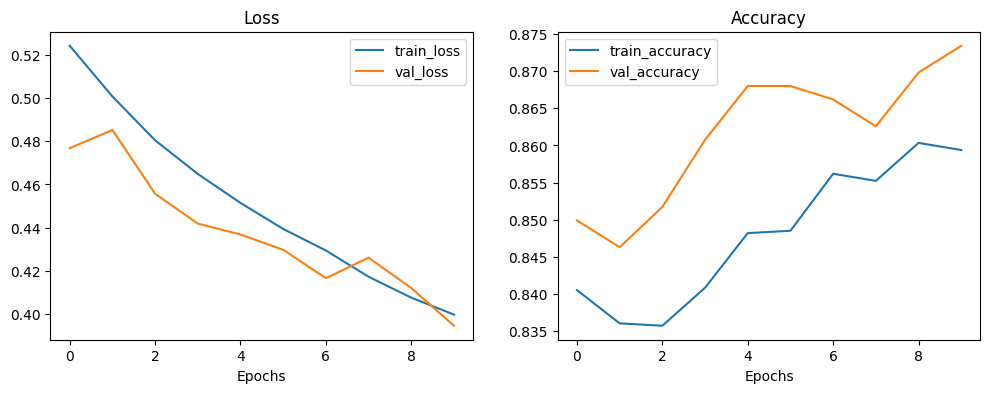

In [ ]:
plot_loss_curves(st_model_history)

## [5] Model Evaluation against Testing Data

In [ ]:
# Evaluate the model on the testing dataset
evaluation_results = st_model.evaluate(X_test.values, y_test)

# The 'evaluation_results' will contain the loss value and any other metrics specified during model compilation.
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

16/16 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.8620
Test Loss: 0.44265151023864746
Test Accuracy: 0.8619999885559082


In [ ]:
# Get predictions on the testing dataset
y_pred_probs = st_model.predict(X_test.values)

# 'y_pred_probs' will be an array of shape (number_of_samples, num_classes), containing the predicted probabilities for each class.
# To get the predicted class labels, use 'argmax' on the predictions along the class axis (axis=1).
y_pred_labels = np.argmax(y_pred_probs, axis=1)
print(y_pred_labels)

16/16 [==============================] - 0s 1ms/step
[5 1 1 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 1 5 5 5 5 1 5 5 5 5 6 5 6 5 5 1 5 5 5 5 5 6 5 5 5 1 5 5 3
 1 3 6 5 5 6 5 0 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 8 8 6 8 8 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 7 2 2 2 2 2
 2 2 5 2 2 2 2 2 2 2 2 2 8 8 6 5 8 8 8 3 5 8 8 8 8 7 8 8 8 8 8 5 8 8 8 8 8
 8 8 8 8 3 5 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 6 3 3
 1 1 1 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 7 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 3
 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 3 4 4 8 4 4 4 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 2 3 3 3 7 1 2 7 7 7 7 7 7 7 5 7 7 7 7 1 7 7 7 7 7 7 7 7 7
 7 7 7 7 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 7 4 4 4 4 4 4 4 4 4 4
 6 4 5 7 5 4 4 4 4 4 4 4 4 0 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 5 6 6
 6 6 5 6 6 6 6 6 6 6 6 5 6 6 6 5 0 3 6 6 6 6 6 5 6 6 5 6 6 5 5 6 6 6 6 5 6
 6 5 6 6 6 6 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 

In [ ]:
# Create the labels for the classification report
labels_cr = ['Communication Services', 'Consumer Combined', 'Energy', 'Financials', 'Health Care',
             'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']
# Generate multiclass classification report based on testing dataset predictions
cr = classification_report(y_test, y_pred_labels, target_names=labels_cr)

# Display classification report
print(cr)

                        precision    recall  f1-score   support

Communication Services       0.79      0.95      0.86        20
     Consumer Combined       0.91      0.83      0.87        90
                Energy       0.88      0.91      0.89        23
            Financials       0.92      0.93      0.92        72
           Health Care       1.00      0.86      0.93        65
           Industrials       0.71      0.84      0.77        75
Information Technology       0.82      0.78      0.80        65
             Materials       0.81      0.86      0.83        29
           Real Estate       0.83      0.77      0.80        31
             Utilities       1.00      1.00      1.00        30

              accuracy                           0.86       500
             macro avg       0.87      0.87      0.87       500
          weighted avg       0.87      0.86      0.86       500



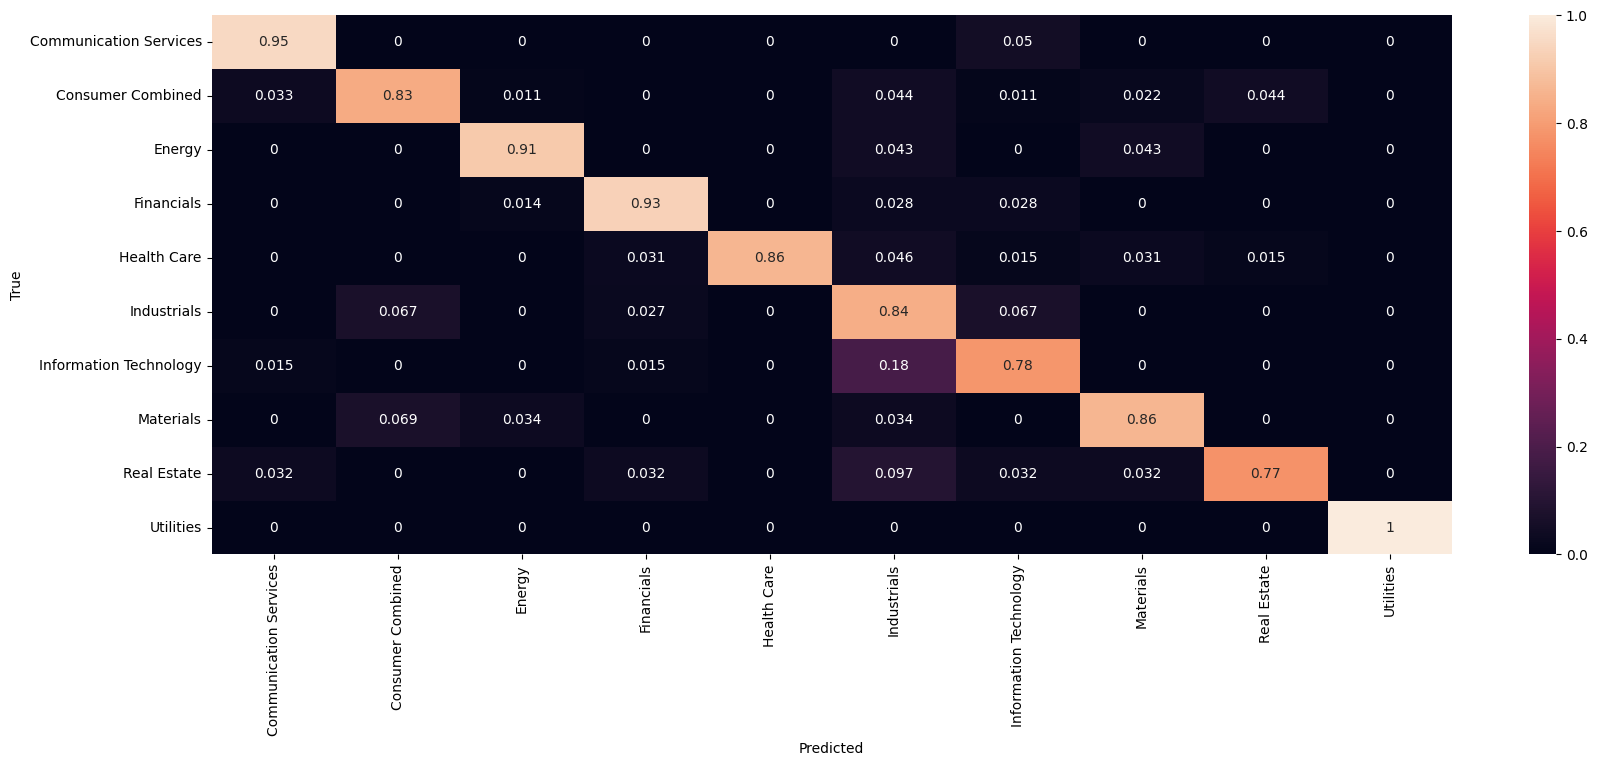

In [ ]:
# Generate a confusion matrix to show testing results by class
cm = tf.math.confusion_matrix(y_test, y_pred_labels)
cm = cm.numpy()
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Display confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    cm_normalized,
    annot=True,
    xticklabels=labels_cr,
    yticklabels=labels_cr)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()